# Whale stalker, whale saver
Explanatory data analsysis for the dataset of the challenge

In [1]:
import os
import pandas as pd

In [2]:
data_folder = os.path.join('..', 'data')
df = pd.read_csv(os.path.join(data_folder, 'train.csv'))

In [3]:
print(f"Number of images: {df.shape[0]}")
print(f"Number of unique species: {df.Id.nunique()}")
print(df.head())

Number of images: 25361
Number of unique species: 5005
           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale


## Display a few samples

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

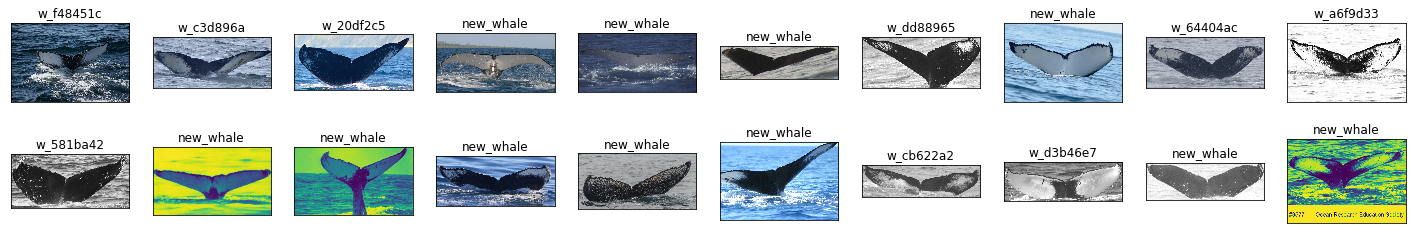

In [5]:
# Display a few examples
classes_to_display = 20

fig = plt.figure(figsize=(25, 4))
for idx in range(classes_to_display):
    img_name = df.Image.iloc[idx]
    img_label = df.Id.iloc[idx]
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = mpimg.imread(os.path.join(data_folder, 'train', img_name))
    plt.imshow(img)
    ax.set_title(img_label)    